In [1]:
from os import path
import pandas as pd
from gensim.models import KeyedVectors
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("http://data.odeuropa.eu/repositories/odeuropa")
sparql.setReturnFormat(JSON)

In [3]:
def label(uri):
    if uri is None or type(uri) != str or len(uri) == 0:
        return None
    if 'flavornet' in uri and len(uri.split('/')) == 6:
        uri = uri.replace('flavornet','flavornet/odors')
        
    q = '''
        PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
        PREFIX onto: <http://www.ontotext.com/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

        SELECT ?label
        FROM onto:explicit
        WHERE {
            <%s> skos:prefLabel|rdfs:label ?label
        }
    ''' % uri
    sparql.setQuery(q)
    ret = sparql.queryAndConvert()
    data = [l['label'] for l in ret['results']['bindings']]
    if len(data) < 1:
        return "smell"
    data.sort(key=lambda l: ('aaa' if l['xml:lang']== 'en' else l['xml:lang']) if 'xml:lang' in l else 0)
    return data[0]['value']

def clean(array):
    return [r for r in array if not pd.isna(r)]
    
def do_nothing(inp):
    return inp

def to_labels(array):
    return [label(r) if str(r).startswith('http') else r for r in array if not pd.isna(r)]

Load all resources

In [4]:
root = './embeddings'
all_data = pd.read_csv('all_data_sorted.csv')

print('Loading voc.kv')
voc_emb = KeyedVectors.load(path.join(root, 'voc.kv'))

Loading voc.kv


/var/folders/1p/7266x_bx2bv6hyhd2_k8nt8m0000gn/T/ipykernel_63584/2892974120.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('all_data_sorted.csv')


In [125]:
print('Loading smells.kv')
smell_emb_path = path.join(root, 'smells.kv')
print(smell_emb_path)
smell_emb = KeyedVectors.load(smell_emb_path)

def get(smell, with_labels=False): 
    res = all_data[all_data['smell'] == smell]
    proc = to_labels if with_labels else do_nothing
    return {
        'source': proc(clean(res['source'].unique().tolist())),
        'carrier': proc(clean(res['carrier'].unique().tolist())),
        'quality': proc(clean(res['quality'].unique().tolist())),
        'quality_type': proc(clean(res['quality_type'].unique().tolist())),
        'place': proc(clean(res['place'].unique().tolist())),
        'place_type': proc(clean(res['place_type'].unique().tolist())),
        'gesture': proc(clean(res['gesture'].unique().tolist())),
        'emotion': proc(clean(res['emotion'].unique().tolist())),
        'time': proc(clean(res['time'].unique().tolist()))
}

Loading smells.kv
./embeddings/smells.kv


In the following, we have a pandas dataframe containing all values for the most important properties of the graph, smell by smell

In [126]:
all_data

,smell,source,carrier,quality,quality_type,place,place_type,gesture,emotion,time
0,http://data.odeuropa.eu/smell/c52b0781-e906-53...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,http://data.odeuropa.eu/vocabulary/drom/spicy,http://data.odeuropa.eu/attribute-type/character,NaN,NaN,NaN,NaN,1903
1,http://data.odeuropa.eu/smell/c52b0781-e906-53...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,http://data.odeuropa.eu/vocabulary/historic-bo...,http://data.odeuropa.eu/attribute-type/character,NaN,NaN,NaN,NaN,1903
2,http://data.odeuropa.eu/smell/ae8a7f2c-eacb-58...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1916
3,http://data.odeuropa.eu/smell/54d263a5-1015-5c...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1916
4,http://data.odeuropa.eu/smell/f61895e3-110e-51...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1867
...,...,...,...,...,...,...,...,...,...,...
241505,http://data.odeuropa.eu/smell/ba377729-4697-5e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1862.0
241506,http://data.odeuropa.eu/smell/cebb7b35-b8a4-5c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1862.0
241507,http://data.odeuropa.eu/smell/1c72f57e-1170-50...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1862.0
241508,http://data.odeuropa.eu/smell/f6463053-02ec-59...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1862.0


In [127]:
only_obj= [l for l in voc_emb.key_to_index.keys() if l.startswith('http://data.odeuropa.eu/vocabulary/olfactory-objects')]
X = voc_emb[only_obj]

In [128]:
n_clusters = 20

In [129]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[ 3  9 16 18  0  6 17 17  6  6 17 17  6 17 17 12 17 17  6  6  6  6  6 17
  6  6  6 17 17 17  6  6  6  6 12 17 12  9  6 13 17 17 17  6  6  6  6  6
 17  6  6 17 17 17 17  6  6 17  6 12  6  6  6  6  6  6 17  6  6  6 17  6
  0  6 16  6  1  1  6 17  6  6  6  1 10  1  6  6 13 17  6 15 15 16 18 14
 14  6 16 18  6 10 15 14  6 15 16  9  7  6 10  9 19  9  1 10 16  9 19 19
 16 19  6  9  9  9  9  9  9  9  9  9 15 15 15 15 15 15  4 15 13 16  1  1
  0 14 14 16 16 16  7 10 19 14 14 16  7  7  7  7  6 16 14 18 16 19 16 18
 19 14 18 16  1 19 19 14 14 18 18  1  6 10  1  1  1  1  1  1  1  1 18 16
  1 18  2 19 19 16 13 13  1  1 16 17  6  6  6  6  6  6  2  2  2  2  2  2
  2  2  2  2  2  7  2  2  2  2  9  9  9  9  9  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  9  3  9  3  3  9  9  9  7  7  9  7  7  7  7  7  9 18  7
  7  9  9 16  2  9  3  9  9  9  9  4  4  9  3  9  9  3 19 19  0  0  0 14
  0  0 14  0  0 18  0  9  3  9 10 10 10 10 10 14  5 10 10  1  1  1  1  1
  1  1 18  2  0

In [130]:
new_centroids = []
for i, x in enumerate(centroids):
    top = voc_emb.most_similar_cosmul(x, topn=5)
    for y in top:
        print(y, label(y[0]))

    new_centroids.append(top[0][0])
    print('%%%%%%%%%%%%%%%')

('http://data.odeuropa.eu/vocabulary/olfactory-objects/419', 3.738182783126831) Stapelia
('http://data.odeuropa.eu/vocabulary/olfactory-objects/139', 3.6763575077056885) Organic waste
('http://data.odeuropa.eu/vocabulary/olfactory-objects/354', 3.672146797180176) Rapeseed
('http://data.odeuropa.eu/vocabulary/olfactory-objects/357', 3.6690845489501953) Fir needle
('http://data.odeuropa.eu/vocabulary/olfactory-objects/356', 3.659223794937134) Pine needle
%%%%%%%%%%%%%%%
('http://data.odeuropa.eu/vocabulary/olfactory-objects/382', 2.2897822856903076) Kerosene
('http://data.odeuropa.eu/vocabulary/olfactory-objects/198', 2.2859995365142822) Sea
('http://data.odeuropa.eu/vocabulary/olfactory-objects/249', 2.2655746936798096) Peat
('http://data.odeuropa.eu/vocabulary/olfactory-objects/383', 2.2565135955810547) Petroleum
('http://data.odeuropa.eu/vocabulary/olfactory-objects/381', 2.240225076675415) Diesel fuel
%%%%%%%%%%%%%%%
('http://data.odeuropa.eu/vocabulary/olfactory-objects/335', 3.8915

In [131]:
# len(only_obj)

import pandas as pd
top_concepts = pd.read_csv('embeddings//top-concepts.csv')
concepts = list(set(top_concepts['sub'].to_list()))

In [132]:
from sklearn.metrics import homogeneity_completeness_v_measure

import numpy as np
from collections import Counter

def flatten_concatenation(matrix):
     flat_list = []
     for row in matrix:
         flat_list += row
     return flat_list

def get_top_concept(t):
    return top_concepts[top_concepts['sub'] == t]['top'].to_list()

classes = [get_top_concept(t) for t in only_obj]

priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.8769583894025732, 0.5827816480303151, 0.700227769773067)

In [133]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(X)

CPU times: user 21.3 s, sys: 8.97 s, total: 30.3 s
Wall time: 3.91 s


In [134]:
df = pd.DataFrame()
df['id'] = only_obj
# df['label'] = df['id'].apply(label)
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

IndexError: index 1822 is out of bounds for axis 0 with size 568

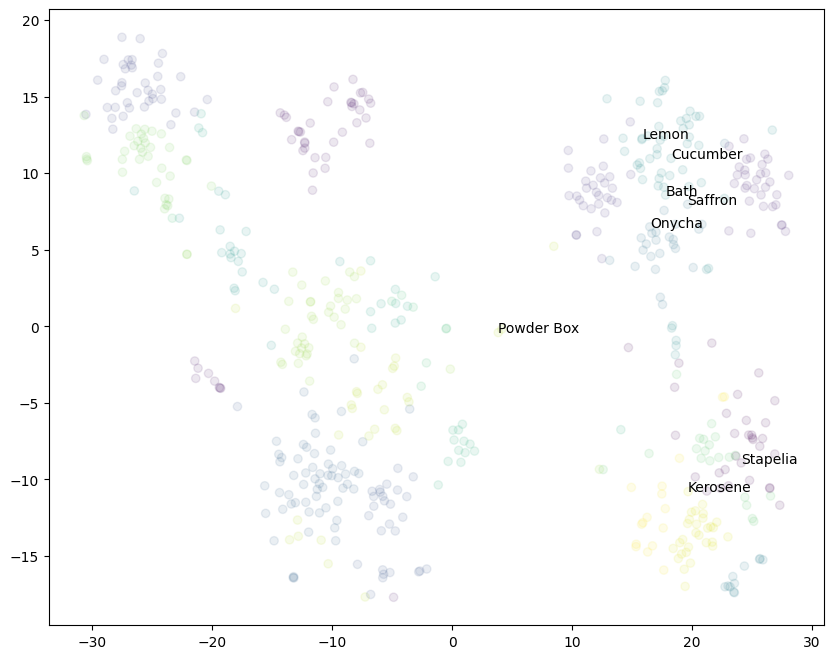

In [135]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(embs[:,0], embs[:,1], c=labels, alpha=.1)

for x in new_centroids:
    coords = embs[voc_emb.key_to_index[x]]
    ax.text(coords[0], coords[1], label(x))

In [ ]:
def get_uri_by_label():
    q = '''
        PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
        PREFIX onto: <http://www.ontotext.com/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

        SELECT ?uri
        FROM onto:explicit
        WHERE {
            ?uri skos:prefLabel|rdfs:label "%s"@en
        }
    ''' % uri
    sparql.setQuery(q)
    ret = sparql.queryAndConvert()
    data = [l['uri'] for l in ret['results']['bindings']]
    if len(data) < 1:
        return None
    return data[0]['value']

In [ ]:
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_label_pattern(pattern, **kwargs):
    """Plot all movies whose labels match the given regex pattern.
    """
    match = df[df.label.str.contains(pattern)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated label column
        labels = mainstream_movies.loc[label_indices, 'label'].values
        texts = []
        for label, x, y in zip(labels, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for id, x, y in zip(pts.id.values, pts.x.values, pts.y.values):
            t = ax.annotate(label(id), xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(label, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given label. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df['id'] == label]
    #assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

In [ ]:
plot_region_around('http://data.odeuropa.eu/vocabulary/olfactory-objects/267')

In [147]:
# Same with Dist Mult
kv = KeyedVectors.load_word2vec_format("embeddings/DistMult_entity.bin", binary=True)
only_obj= [l for l in kv.key_to_index.keys() if l.startswith('http://data.odeuropa.eu/vocabulary/olfactory-objects')]
CATS = ['http://data.odeuropa.eu/vocabulary/olfactory-objects/artifact','http://data.odeuropa.eu/vocabulary/olfactory-objects/carrier','http://data.odeuropa.eu/vocabulary/olfactory-objects/smell-source','http://data.odeuropa.eu/vocabulary/olfactory-objects/smell_carrier']
only_obj = [l for l in only_obj if l not in CATS]
        
X = kv[only_obj]

In [148]:
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

Cluster id labels for inputted data
[19  3  3 18 18 12  8  8  3  4  2  9 19  5  3  9  0 19 19 19 19 19  0  6
 19 19 16 19  3 16  4  3  3 19 17  3  3  3  3  3  4  3 19  8  1 17  3  3
 19  3 19  6 17 14 19  3  9 15 16  3 17 12  9  3  3 16  3  9  6  9 13 14
  9 15  6 12  3  9  6  8 13  9  2 13  8  3  9  9 19  1 16  9  5  9  5  9
  9  9 11 17 19 17 17 17 17 18 17  3 12  4  4 19  7  1 10  1 12 12 12  9
  6  4  1 16  1 10 12  9  9 12  6 12  1 13  9 12 13 12  1 10 12  8 16  2
  2  6 12  1  1  4  8  1 13 13  2  1 12  3  6 15 15  9  4  4 15 15  4 16
 13  3  0  0  2 13  5  8  8 12  4  3  4  4  4 19 15 15 12  1 12  8  6  7
  3  3  3  9 10  5  5  9  3  5 16  5  5  5  5  5  5  5  9  3  5  5  5  5
  5  5  9  5  5  5 19 19  5  9  5  5  5  5  5  5  5  5  7  5  5  5  5 10
  9  5  5  9  5 16  9  9 10  9  9  9  9  9  9 13 15  9  9  9  5  0  5  9
  9  9  9 16  5  9  5 18  9 12  9  5  5  9  9  8  1  1  1 10  1 10 13  1
  1  9  1  1  8  9  9  9  6  6  6  6  0 10  6 13  3 16  6  6  2  2  4 19
  4  4  4  4 13

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [152]:
new_centroids = []
for i, x in enumerate(centroids):
    top = kv.most_similar_cosmul(x, topn=15)
    for y in top:
        print(y, label(y[0]))

    new_centroids.append(top[0][0])
    print('%%%%%%%%%%%%%%%')

('http://www.wikidata.org/entity/Q131746', 0.8454304337501526) smell
('http://www.wikidata.org/entity/Q30748525', 0.8440115451812744) smell
('http://www.wikidata.org/entity/Q2863', 0.841728925704956) smell
('http://www.wikidata.org/entity/Q203015', 0.8415057063102722) smell
('http://data.odeuropa.eu/vocabulary/olfactory-objects/60', 0.8384787440299988) Eau de Luce
('http://data.odeuropa.eu/vocabulary/olfactory-objects/252', 0.8379432559013367) Boldoot
('http://data.odeuropa.eu/vocabulary/olfactory-objects/65', 0.8363078236579895) Perfume
('http://data.odeuropa.eu/vocabulary/olfactory-objects/401', 0.834652841091156) Acqua della Regina
('http://www.wikidata.org/entity/Q837648', 0.8256344199180603) smell
('http://data.odeuropa.eu/vocabulary/olfactory-objects/113', 0.8255779147148132) Peau d'Espagne
('http://data.odeuropa.eu/vocabulary/olfactory-objects/59', 0.8251728415489197) Eau de Hungary
('http://data.odeuropa.eu/vocabulary/olfactory-objects/253', 0.8236309289932251) Fougère
('http:/

In [154]:
classes = [get_top_concept(t) for t in only_obj]

priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')
            print(only_obj[i])

homogeneity_completeness_v_measure(classes_flat, labels)

(0.8213505691472083, 0.5623813084784428, 0.6676325309338352)

In [155]:
# Same with TransE
kv = KeyedVectors.load_word2vec_format("embeddings/TransE_entity.bin", binary=True)
only_obj= [l for l in kv.key_to_index.keys() if l.startswith('http://data.odeuropa.eu/vocabulary/olfactory-objects')]
only_obj = [l for l in only_obj if l not in CATS]
X = kv[only_obj]

In [156]:
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[16  5  5 15 11  9 13  1  3  4  6  6  5 13  5 11  4 17  5 17 16 17  6 12
 17 17  9 17 15  6  8 15  5  5 18 11 15 15  2  5 16 11 10 12 11 11  9 11
  5 15  8  0  4 14  7 16 16 16  6  8  5  4  0  3 16  9  5  5 16 11 12 13
 17 13  5 12  7 14 13 12 10 19  5 12  0 16 14  3 12  8  8  5 11 13 13 16
  4  5  1  9  5 11 11 12 13 17 16  2 16  8  8  5  5  0 13  6 17  5  5 16
 13 16 17  9  6  4 13  3 12  9 19 11 11  8 10 19 11  4  1 12  5 13  6 11
 10  8 12 12 16  0 17  4 11 11 13 17  8  5 17  1 19  4  4  5 16 16  6  9
 10 11  5  3 11 15 11 13 13  0 11  5 12 13  4  1  5 16 13  5  9  8 13 17
  3  5 16  4 16  5  5 16 17  5  0 11 17 17 13 11 14 16 13  1 13  5  5 16
 11  5  4 13 11 11 13  5  5  1 17  9  5 12 11 16 11  5  5 12 13 17  1 11
  3 11  5 11 17 12 12 19 11  3  5 16  5  5  4 17 18  3  5 14 11  3  9 11
  3 14 13  9  5 16  5 17 12 11 12  5  5  5 11 13 11  5 11 17 11  5  5  8
 19  3 10 12  8  5 11 11 13  6 10 10  5  6 11 12  3  5  1  5 12 17 13 15
  5 11  4 16 10

In [160]:
new_centroids = []
for i, x in enumerate(centroids):
    top = kv.most_similar_cosmul(x, topn=15)
    for y in top:
        print(y, label(y[0]))

    new_centroids.append(top[0][0])
    print('%%%%%%%%%%%%%%%')

('http://data.odeuropa.eu/vocabulary/olfactory-objects/233', 0.7959763407707214) Leather
('http://data.odeuropa.eu/vocabulary/olfactory-objects/65', 0.7907360196113586) Perfume
('http://data.odeuropa.eu/vocabulary/olfactory-objects/403', 0.7862532138824463) Vegetable
('http://data.odeuropa.eu/vocabulary/olfactory-objects/175', 0.7817427515983582) Lily-of-the-valley
('http://www.wikidata.org/entity/Q2095', 0.7789011597633362) smell
('http://www.wikidata.org/entity/Q131746', 0.7775019407272339) smell
('http://data.odeuropa.eu/vocabulary/olfactory-objects/75', 0.7733778953552246) Fruit
('http://data.odeuropa.eu/vocabulary/olfactory-objects/445', 0.7725152969360352) Melon
('http://www.wikidata.org/entity/Q287', 0.772499680519104) smell
('http://data.odeuropa.eu/vocabulary/olfactory-objects/471', 0.7722351551055908) Insect
('http://www.wikidata.org/entity/Q5881191', 0.7711753845214844) smell
('http://www.wikidata.org/entity/Q496', 0.7704300880432129) smell
('http://data.odeuropa.eu/vocabula

In [158]:
classes = [get_top_concept(t) for t in only_obj]

priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.1613775708993373, 0.11112330731478472, 0.13161652558542963)

In [159]:
len(only_obj)

565

In [65]:
all_data = pd.read_csv('all_props.csv', sep=',', index_col=0)
SOURCE = 'od_F3_had_source%20%2F%20ecrm_P137_exemplifies'
all_data

/var/folders/1p/7266x_bx2bv6hyhd2_k8nt8m0000gn/T/ipykernel_18356/3932829861.py:1: DtypeWarning: Columns (2,3,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('all_props.csv', sep=',', index_col=0)


,smell,od_F6_evoked%20%2F%20ecrm_P137_exemplifies,od_F5_involved_gesture%20%2F%20ecrm_P137_exemplifies,od_F4_had_carrier%20%2F%20ecrm_P137_exemplifies,%5Eecrm_P140_assigned_attribute_to%20%2F%20ecrm_P141_assigned,od_F3_had_source%20%2F%20ecrm_P137_exemplifies,ecrm_P7_took_place_at%20%2F%20ecrm_P137_exemplifies
0,http://data.odeuropa.eu/experience/5a4850db-7f...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN
1,http://data.odeuropa.eu/experience/ad644f44-d1...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN
2,http://data.odeuropa.eu/experience/21b16c3c-d3...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN
3,http://data.odeuropa.eu/experience/28ab7efb-2d...,http://data.odeuropa.eu/vocabulary/olfactory-o...,NaN,NaN,NaN,NaN,NaN
4,http://data.odeuropa.eu/experience/3ab179a4-f0...,http://data.odeuropa.eu/vocabulary/fragrant-sp...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1173906,http://data.odeuropa.eu/smell/13df9c06-507c-55...,NaN,NaN,NaN,NaN,NaN,http://data.odeuropa.eu/vocabulary/fragrant-sp...
1173907,http://data.odeuropa.eu/experience/a2102894-d6...,NaN,NaN,NaN,NaN,NaN,http://data.odeuropa.eu/vocabulary/fragrant-sp...
1173908,http://data.odeuropa.eu/experience/d406b1d8-eb...,NaN,NaN,NaN,NaN,NaN,http://data.odeuropa.eu/vocabulary/fragrant-sp...
1173909,http://data.odeuropa.eu/smell/e4f25cb1-1f09-58...,NaN,NaN,NaN,NaN,NaN,http://data.odeuropa.eu/vocabulary/fragrant-sp...


In [97]:
filtered_all_data = all_data[all_data[SOURCE].notna()]
only_smells= [l for l in smell_emb.key_to_index.keys()] # if l.startswith('http://data.odeuropa.eu/vocabulary/olfactory-objects')]
onl_obj = set(only_smells).intersection(set(filtered_all_data['smell']))

X = smell_emb[onl_obj]

len(onl_obj)

140524

In [98]:
from tqdm.notebook import tqdm

all_classes = {}
for i, x in tqdm(filtered_all_data.iterrows(), total=len(filtered_all_data)):
    sm = x['smell']
    source = x[SOURCE]
    if sm not in all_classes:
        all_classes[sm] = []
    all_classes[sm].append(source)

  0%|          | 0/663054 [00:00<?, ?it/s]

In [99]:
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[0 0 0 ... 4 9 0]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-19064.763671875


In [100]:
def get_source(k, single=True):
    sources =  all_data[all_data['smell']==k][SOURCE]
    if not single:
        return sources.tolist()
    if len(sources) > 0:
        return sources.tolist()[0]
    else:
        return ''

def get_prop(k, p):
    sources =  all_data[all_data['smell']==k][p]
    if len(sources) > 0:
        return sources.tolist()[0]
    else:
        return ''

In [101]:
classes = [all_classes[t] for t in tqdm(onl_obj)]
top_classes = []
for c in tqdm(classes):
    top_classes.append(flatten_concatenation([get_top_concept(s) for s in c]))

  0%|          | 0/140524 [00:00<?, ?it/s]

  0%|          | 0/140524 [00:00<?, ?it/s]

In [102]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.04378552534138674, 0.12150237300566948, 0.06437307613540862)

In [103]:
classes[126]

['http://data.odeuropa.eu/vocabulary/olfactory-objects/21',
 'http://data.odeuropa.eu/vocabulary/olfactory-objects/22']

In [104]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([top_classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(top_classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            classes_flat.append('other')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.031434816709643515, 0.032496155089255636, 0.031956676091586964)

In [105]:
new_centroids = []
for i, x in enumerate(centroids):
    
    print(f'Cluster {i} - {labels.tolist().count(i)} elements ')
    top = smell_emb.most_similar(x, topn=5)
    for y in top:
        print(y, label(y[0]), '|' ,  label(get_source(y[0])))
        print(label(get_prop(y[0], '%5Eecrm_P140_assigned_attribute_to%20%2F%20ecrm_P141_assigned')),
             '|' , label(get_prop(y[0], 'od_F4_had_carrier%20%2F%20ecrm_P137_exemplifies')),
             '|' , label(get_prop(y[0], 'od_F5_involved_gesture%20%2F%20ecrm_P137_exemplifies')))

    new_centroids.append(top[0][0])
    print('%%%%%%%%%%%%%%%')

Cluster 0 - 73185 elements 
('http://data.odeuropa.eu/smell/6fcb9ffe-e73e-5924-9d49-6f78169b90ad', 0.41874897480010986) smell | Peach
None | Glass without stem | None
('http://data.odeuropa.eu/smell/a3a6ceeb-4b13-550f-a012-01ce9fb9211f', 0.4054718613624573) smell | Butterfly
None | None | None
('http://data.odeuropa.eu/smell/a4ec333c-d74d-5642-8f9b-a85c9315560b', 0.37610024213790894) parfum | Feather
None | None | None
('http://data.odeuropa.eu/smell/cd52d354-f4af-5064-a4d6-aea9971a9a4e', 0.373218834400177) smell | Flower
None | None | None
('http://data.odeuropa.eu/smell/aa998597-737c-527a-97ea-897adc900167', 0.37003615498542786) stink | Fish
None | None | None
%%%%%%%%%%%%%%%
Cluster 1 - 4567 elements 
('http://data.odeuropa.eu/smell/62fb5dbd-280c-5546-98b5-935077d0694c', 0.9923573732376099) smell | None
None | None | None
('http://data.odeuropa.eu/smell/33f2a429-4292-586d-ba13-3bb884959c70', 0.9895732402801514) odeur | None
None | None | None
('http://data.odeuropa.eu/smell/ea8b20d3

In [106]:
new_centroids = []
for i, x in enumerate(centroids):
    
    print(f'Cluster {i} - {labels.tolist().count(i)} elements ')
    top = smell_emb.most_similar(x, topn=5)
    for y in top:
        print(y, label(y[0]), '|' ,  label(get_source(y[0])))
        print(label(get_prop(y[0], '%5Eecrm_P140_assigned_attribute_to%20%2F%20ecrm_P141_assigned')),
             '|' , label(get_prop(y[0], 'od_F4_had_carrier%20%2F%20ecrm_P137_exemplifies')),
             '|' , label(get_prop(y[0], 'od_F5_involved_gesture%20%2F%20ecrm_P137_exemplifies')))

    new_centroids.append(top[0][0])
    print('%%%%%%%%%%%%%%%')

Cluster 0 - 73185 elements 
('http://data.odeuropa.eu/smell/6fcb9ffe-e73e-5924-9d49-6f78169b90ad', 0.41874897480010986) smell | Peach
None | Glass without stem | None
('http://data.odeuropa.eu/smell/a3a6ceeb-4b13-550f-a012-01ce9fb9211f', 0.4054718613624573) smell | Butterfly
None | None | None
('http://data.odeuropa.eu/smell/a4ec333c-d74d-5642-8f9b-a85c9315560b', 0.37610024213790894) parfum | Feather
None | None | None
('http://data.odeuropa.eu/smell/cd52d354-f4af-5064-a4d6-aea9971a9a4e', 0.373218834400177) smell | Flower
None | None | None
('http://data.odeuropa.eu/smell/aa998597-737c-527a-97ea-897adc900167', 0.37003615498542786) stink | Fish
None | None | None
%%%%%%%%%%%%%%%
Cluster 1 - 4567 elements 
('http://data.odeuropa.eu/smell/62fb5dbd-280c-5546-98b5-935077d0694c', 0.9923573732376099) smell | None
None | None | None
('http://data.odeuropa.eu/smell/33f2a429-4292-586d-ba13-3bb884959c70', 0.9895732402801514) odeur | None
None | None | None
('http://data.odeuropa.eu/smell/ea8b20d3

In [ ]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1500, metric="cosine")

embs = tsne.fit_transform(X)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(embs[:,0], embs[:,1], c=labels, alpha=.1)

for x in new_centroids:
    coords = embs[smell_emb.key_to_index[x]]
    ax.text(coords[0], coords[1], label(get_source(x)))

In [109]:
# Same with DistMult 
kv = KeyedVectors.load_word2vec_format("embeddings/DistMult_entity.bin", binary=True)

In [110]:
only_smells = [l for l in kv.key_to_index.keys() if l.startswith('http://data.odeuropa.eu/smell')]
len(only_smells)

928953

In [111]:
onl_obj = set(only_smells).intersection(set(filtered_all_data['smell']))

X = kv[onl_obj]

kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[4 7 8 ... 7 6 7]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-68396.3828125


In [112]:
classes = [all_classes[t] for t in tqdm(onl_obj)]
top_classes = []
for c in tqdm(classes):
    top_classes.append(flatten_concatenation([get_top_concept(s) for s in c]))

  0%|          | 0/95730 [00:00<?, ?it/s]

  0%|          | 0/95730 [00:00<?, ?it/s]

In [113]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.05984472402166115, 0.14034683832372183, 0.08390980826959449)

In [114]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([top_classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(top_classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            classes_flat.append('other')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.04525258060903521, 0.03818723721448494, 0.04142077668337664)

In [115]:
# Same with TransE 
kv = KeyedVectors.load_word2vec_format("embeddings/TransE_entity.bin", binary=True)

In [116]:
only_smells = [l for l in kv.key_to_index.keys() if l.startswith('http://data.odeuropa.eu/smell')]

In [117]:
onl_obj = set(only_smells).intersection(set(filtered_all_data['smell']))

X = kv[onl_obj]

kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[7 1 9 ... 1 3 1]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-81400.984375


In [118]:
classes = [all_classes[t] for t in tqdm(onl_obj)]
top_classes = []
for c in tqdm(classes):
    top_classes.append(flatten_concatenation([get_top_concept(s) for s in c]))

  0%|          | 0/95730 [00:00<?, ?it/s]

  0%|          | 0/95730 [00:00<?, ?it/s]

In [119]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            print('error')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.05168353755353398, 0.13168866983617014, 0.07423301938431903)

In [120]:
priorities = []
for clust in set(labels):
    ps = np.where(labels==clust)[0]
    members = flatten_concatenation([top_classes[x] for x in ps])
    counting = dict(Counter(members))
    priority = sorted([id for id in counting.items()],key=lambda a: a[1], reverse= True)
    priority = [a[0] for a in priority]
    priorities.append(priority)
    
classes_flat = []
for i, x in enumerate(top_classes):
    if len(x) == 1:
        classes_flat.append(x[0])
    else:
        done = False
        
        for p in priorities[labels[i]]:
            if p in x:
                classes_flat.append(p)
                done = True
                break
        if not done:
            classes_flat.append('other')

homogeneity_completeness_v_measure(classes_flat, labels)

(0.04076327918092722, 0.037380374506120216, 0.03899860244525932)